In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from timm import create_model
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=[
    "Background",
    "NT_stroma",
    "NT_Muscle",
    "NT_immune",
    "NT_epithelial",
    "NT_gastritis",
    "NT_intestinal_metaplasia",
    "Tumor",
    "Tumor_diffuse",
    "Tumor_intestinal"
]
class_integrate_list={
    "Background":[0],
    "NT_epithelial":[4,5,6],
    "NT_stroma":[1,2,3],
    "Tumor":[7,8,9]
}
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result
    
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
img_path='../../../data/NIPA/stomach/images/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/images/','/masks/') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]

class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        

    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image,label = self.img_path[idx],self.label[idx]
        
        image,label = self.trans(image,label)
        
        return image, label
dataset_image_list=[]
dataset_label_list=[]
for i in tqdm(range(len(img_list))):
    image = tf(Image.open(img_list[i]))
    label_path=mask_list[i]
    label=torch.from_numpy(np.load(label_path)).float()
    label=label.permute(2,0,1)
    if class_integrate_list is not None:
        temp_label = torch.zeros((len(class_integrate_list),label.shape[1],label.shape[2]))
        for i, key in enumerate(class_integrate_list.keys()):
            for cls in class_integrate_list[key]:
                temp_label[i] = temp_label[i] + label[cls]
        label = torch.clamp(temp_label,0,1)
    dataset_image_list.append(image)
    dataset_label_list.append(label)
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(dataset_image_list,dataset_label_list,test_size=0.2,random_state=41)
train_dataset = CustomDataset(train_img_list, train_mask_list)

test_dataset = CustomDataset(test_img_list, test_mask_list)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# 데이터셋 시각화 - 원본, 마스크, 오버레이
import matplotlib.pyplot as plt

# 색상 맵 정의 (통합된 클래스용)
integrated_color_map = {
    0: [255, 255, 255],  # Background - White
    1: [255, 0, 255],    # NT_epithelial - Magenta
    2: [0, 255, 0],      # NT_stroma - Green
    3: [255, 0, 0],      # Tumor - Red
}

# 통합된 클래스 이름
integrated_class_names = list(class_integrate_list.keys())

# 첫 번째 샘플 가져오기
image, mask = train_dataset[0]

# numpy로 변환
image_np = image.numpy().transpose(1, 2, 0)  # CHW -> HWC
mask_np = mask.numpy()  # (C, H, W)

# 마스크를 RGB로 변환
mask_argmax = np.argmax(mask_np, axis=0)  # (H, W)
mask_rgb = np.zeros((mask_np.shape[1], mask_np.shape[2], 3), dtype=np.uint8)

for class_idx, color in integrated_color_map.items():
    mask_rgb[mask_argmax == class_idx] = color

# 오버레이 이미지 생성
alpha = 0.5  # 투명도
overlay_img = (image_np * 255).astype(np.uint8)

# 배경 제외하고 오버레이
for class_idx, color in integrated_color_map.items():
    if class_idx == 0:  # 배경 제외
        continue
    mask_area = (mask_argmax == class_idx)
    if mask_area.any():
        color_array = np.array(color, dtype=np.uint8)
        overlay_img[mask_area] = (1 - alpha) * overlay_img[mask_area] + alpha * color_array

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 원본 이미지
axes[0].imshow(image_np)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# 마스크
axes[1].imshow(mask_rgb)
axes[1].set_title('Ground Truth Mask', fontsize=14, fontweight='bold')
axes[1].axis('off')

# 오버레이
axes[2].imshow(overlay_img)
axes[2].set_title('Original + Mask Overlay', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 클래스별 색상 범례 표시
plt.figure(figsize=(10, 2))
for i, (class_idx, color) in enumerate(integrated_color_map.items()):
    plt.barh(0, 1, left=i, color=np.array(color)/255.0, edgecolor='black', linewidth=2)
    plt.text(i+0.5, 0, integrated_class_names[class_idx], 
             ha='center', va='center', fontsize=12, fontweight='bold')

plt.xlim(0, len(integrated_color_map))
plt.ylim(-0.5, 0.5)
plt.title('Class Color Legend', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# 이미지 정보 출력
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Number of classes: {len(integrated_class_names)}")
print(f"Class names: {integrated_class_names}")
print(f"\nClass distribution in this sample:")
for class_idx, class_name in enumerate(integrated_class_names):
    pixel_count = (mask_argmax == class_idx).sum()
    percentage = (pixel_count / (mask_np.shape[1] * mask_np.shape[2])) * 100
    print(f"  {class_name}: {pixel_count} pixels ({percentage:.2f}%)")

In [ ]:
model = model = smp.UPerNet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(class_integrate_list),
).to(device)
def dice_loss(pred, target, ignore_index=[0,2]):
    smooth = 1e-6
    pred = F.softmax(pred, dim=1)
    
    # 무시할 클래스를 제외한 클래스만 선택
    num_classes = pred.shape[1]
    valid_classes = [i for i in range(num_classes) if i not in ignore_index]
    
    dice_per_class = torch.zeros(len(valid_classes)).to(pred.device)
    
    for idx, class_idx in enumerate(valid_classes):
        pred_class = pred[:, class_idx, :, :]
        target_class = target[:, class_idx, :, :]
        
        intersection = torch.sum(pred_class * target_class)
        A_sum = torch.sum(pred_class * pred_class)
        B_sum = torch.sum(target_class * target_class)
        dice_per_class[idx] = (2. * intersection + smooth) / (A_sum + B_sum + smooth)
    
    return 1 - dice_per_class.mean()


def focal_loss(pred, target, alpha=0.25, gamma=2.0, ignore_index=[0, 2]):
    """Focal Loss for multi-class segmentation"""
    pred = F.softmax(pred, dim=1)
    
    num_classes = pred.shape[1]
    valid_classes = [i for i in range(num_classes) if i not in ignore_index]
    
    focal_per_class = torch.zeros(len(valid_classes)).to(pred.device)
    
    for idx, class_idx in enumerate(valid_classes):
        pred_class = pred[:, class_idx, :, :]
        target_class = target[:, class_idx, :, :]
        
        # Focal loss 계산
        bce = -(target_class * torch.log(pred_class + 1e-6) + 
                (1 - target_class) * torch.log(1 - pred_class + 1e-6))
        
        pt = torch.where(target_class == 1, pred_class, 1 - pred_class)
        focal_weight = (1 - pt) ** gamma
        focal_per_class[idx] = (alpha * focal_weight * bce).mean()
    
    return focal_per_class.mean()

def combined_loss(pred, target, ignore_index=[0, 2], dice_weight=0.5, focal_weight=0.5):
    """Dice Loss + Focal Loss 결합"""
    dice = dice_loss(pred, target, ignore_index)
    focal = focal_loss(pred, target, ignore_index=ignore_index)
    return dice,dice_weight * dice + focal_weight * focal
model.load_state_dict(torch.load('../../../model/ST_HnE_tumor/ST_callback.pt'))
# summary(model,(batch_size,3,img_size,img_size))

In [ ]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
model_path='../../../model/ST_HnE_tumor/'
create_dir(model_path)
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        dicecost, cost = combined_loss(predict, y) # cost 구함
        acc=1-dicecost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} combined_loss : {running_loss/count:.4f} combined_score: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), f'{model_path}ST_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_combined_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_dice_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_dice')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_dice')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_combined_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_dice_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_dice')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_dice')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')

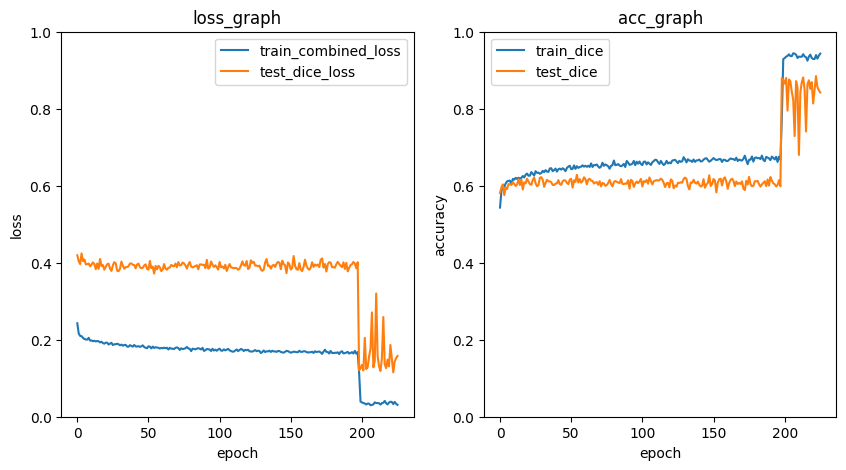

batch size= 2
image size= 1024,1024
learning rate= 2e-4


In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch),train_loss_list,label='train_combined_loss')
plt.plot(np.arange(epoch),val_loss_list,label='test_dice_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch),train_acc_list,label='train_dice')
plt.plot(np.arange(epoch),val_acc_list,label='test_dice')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')

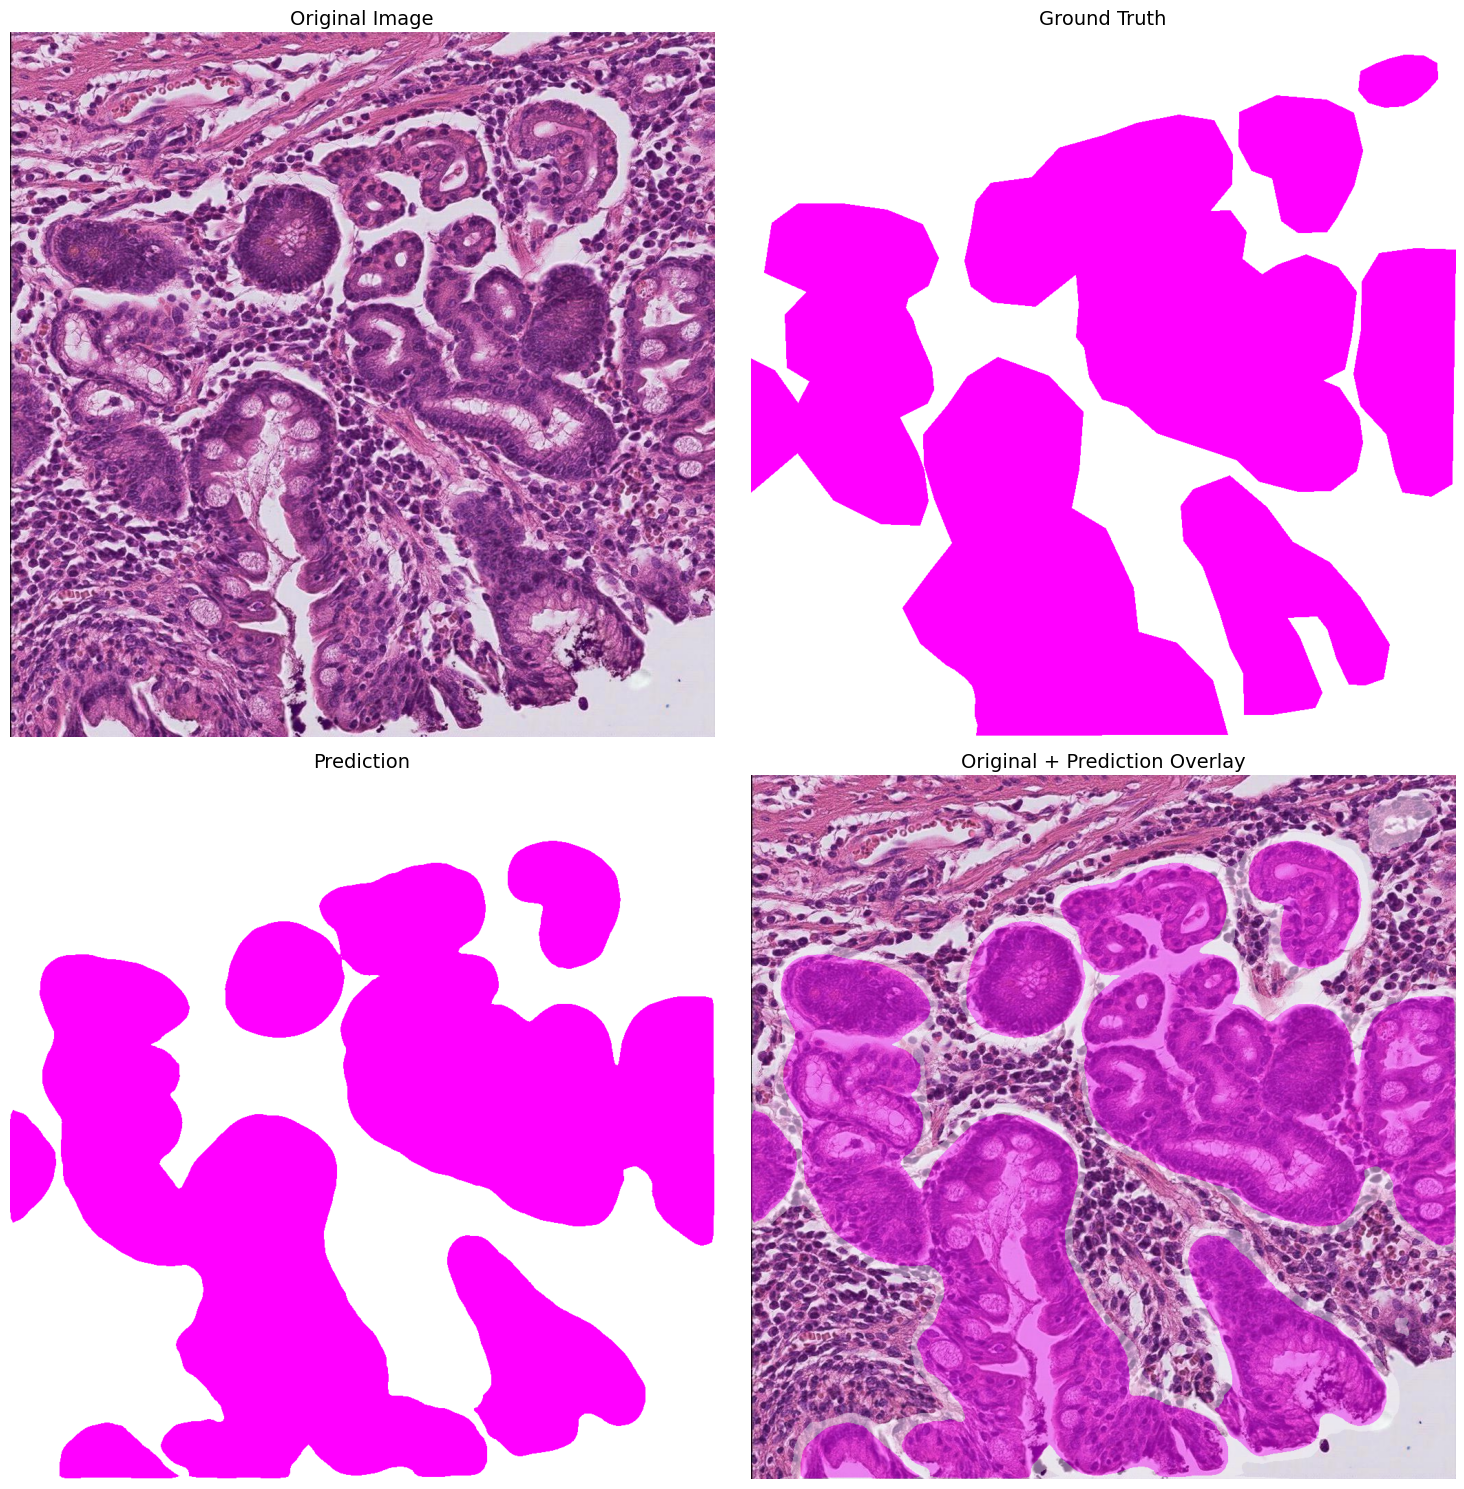

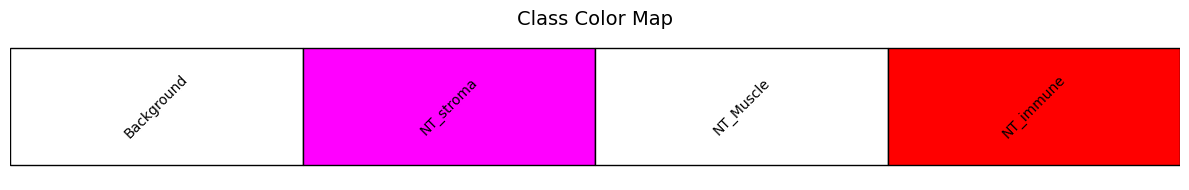

In [39]:
# color_map = {
#     0: [255, 255, 255], # Background - White
#     1: [0, 255, 0],     # NT_stroma - Green
#     2: [255, 255, 0],   # NT_Muscle - Yellow
#     3: [0, 0, 255],   # NT_immune - Blue
#     4: [255, 0, 255],   # NT_epithelial - Magenta
#     5: [0, 255, 255],   # NT_gastritis - Cyan
#     6: [128, 0, 128],   # NT_intestinal_metaplasia - Purple
#     7: [255, 0, 0],   # Tumor - Red
#     8: [128, 128, 0],   # Tumor_diffuse - Olive
#     9: [0, 128, 128],   # Tumor_intestinal - Teal
    
# }
color_map = {
    0: [255, 255, 255],  # Background - White
    1: [255, 0, 255],    # NT_epithelial - Magenta
    2: [255, 255, 255],      # NT_stroma - Green
    3: [255, 0, 0],      # Tumor - Red
}
model.eval()
with torch.no_grad():
    # 테스트 데이터에서 첫 번째 배치 가져오기
    test_iter = iter(test_dataloader)
    x_test, y_test = next(test_iter)
    
    # GPU로 이동
    x_test = x_test.to(device).float()
    y_test = y_test.to(device).float()
    
    # 모델 예측
    predict = model(x_test)
    predict_softmax = F.softmax(predict, dim=1)
    predict_argmax = torch.argmax(predict_softmax, dim=1)
    
    # CPU로 이동하여 numpy로 변환
    x_test_np = x_test.cpu().numpy()
    y_test_np = y_test.cpu().numpy() 
    predict_np = predict_argmax.cpu().numpy()
    
    # 배치에서 첫 번째 이미지만 시각화
    batch_idx = 0
    
    # 원본 이미지 준비 (CHW -> HWC)
    original_img = np.transpose(x_test_np[batch_idx], (1, 2, 0))
    
    # Ground Truth 마스크를 RGB로 변환
    gt_mask_rgb = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    gt_argmax = np.argmax(y_test_np[batch_idx], axis=0)
    for class_idx, color in color_map.items():
        gt_mask_rgb[gt_argmax == class_idx] = color
    
    # Prediction 마스크를 RGB로 변환
    pred_mask_rgb = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    for class_idx, color in color_map.items():
        pred_mask_rgb[predict_np[batch_idx] == class_idx] = color
    
    # 오버랩 결과 생성 (원본 이미지 + 예측 마스크)
    alpha = 0.4  # 투명도
    overlay_img = (original_img * 255).astype(np.uint8)  # 0-1 범위를 0-255로 변환
    
    # 예측 마스크를 오버랩 (배경 제외)
    for class_idx, color in color_map.items():
        if class_idx == 0:  # 배경은 제외
            continue
        mask_area = (predict_np[batch_idx] == class_idx)
        if mask_area.any():
            # 색상을 numpy array로 변환하고 오버레이 적용
            color_array = np.array(color, dtype=np.uint8)
            overlay_img[mask_area] = (1 - alpha) * overlay_img[mask_area] + alpha * color_array
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # 원본 이미지
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image', fontsize=14)
    axes[0, 0].axis('off')
    
    # Ground Truth
    axes[0, 1].imshow(gt_mask_rgb)
    axes[0, 1].set_title('Ground Truth', fontsize=14)
    axes[0, 1].axis('off')
    
    # Prediction
    axes[1, 0].imshow(pred_mask_rgb)
    axes[1, 0].set_title('Prediction', fontsize=14)
    axes[1, 0].axis('off')
    
    # Overlay (원본 + 예측)
    axes[1, 1].imshow(overlay_img.astype(np.uint8))
    axes[1, 1].set_title('Original + Prediction Overlay', fontsize=14)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 클래스별 색상 범례 표시
    plt.figure(figsize=(12, 2))
    for i, (class_idx, color) in enumerate(color_map.items()):
        plt.barh(0, 1, left=i, color=np.array(color)/255.0, edgecolor='black')
        plt.text(i+0.5, 0, class_list[class_idx], ha='center', va='center', 
                rotation=45, fontsize=10)
    
    plt.xlim(0, len(color_map))
    plt.ylim(-0.5, 0.5)
    plt.title('Class Color Map', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 테스트셋 성능 평가 (논문용)
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
# seaborn import 수정
try:
    import seaborn as sns
except:
    print("seaborn 사용 불가, matplotlib만 사용합니다.")
    sns = None

def calculate_dice_coefficient(pred, target, smooth=1e-6):
    """클래스별 Dice coefficient 계산"""
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def calculate_iou(pred, target, smooth=1e-6):
    """클래스별 IoU 계산"""
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def calculate_95_ci(data):
    """95% 신뢰구간 계산"""
    mean = np.mean(data)
    se = stats.sem(data)  # Standard Error
    ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=se)
    return mean, ci

# 통합된 클래스 정보
integrated_class_names = list(class_integrate_list.keys())
num_classes = len(integrated_class_names)

# ignore할 클래스 인덱스 (Background=0, NT_stroma=2)
ignore_index = [0, 2]
valid_classes = [i for i in range(num_classes) if i not in ignore_index]
valid_class_names = [integrated_class_names[i] for i in valid_classes]

print(f"평가할 클래스: {valid_class_names}")
print(f"제외된 클래스: {[integrated_class_names[i] for i in ignore_index]}")

# 테스트셋 전체 평가
model.eval()
all_predictions = []
all_targets = []
all_dice_scores = {i: [] for i in valid_classes}
all_iou_scores = {i: [] for i in valid_classes}
pixel_accuracies = []

print("\n테스트셋 평가 중...")
with torch.no_grad():
    for batch_idx_eval, (x_test_eval, y_test_eval) in enumerate(tqdm(test_dataloader)):
        # GPU로 이동
        x_test_eval = x_test_eval.to(device).float()
        y_test_eval = y_test_eval.to(device).float()
        
        # 모델 예측
        predict_eval = model(x_test_eval)
        predict_softmax_eval = F.softmax(predict_eval, dim=1)
        predict_argmax_eval = torch.argmax(predict_softmax_eval, dim=1)
        
        # CPU로 이동하여 numpy로 변환
        y_test_eval_np = y_test_eval.cpu().numpy() 
        predict_eval_np = predict_argmax_eval.cpu().numpy()
        
        # 각 이미지에 대해 처리
        for i in range(predict_eval_np.shape[0]):
            y_true = np.argmax(y_test_eval_np[i], axis=0)  # (H, W)
            y_pred = predict_eval_np[i]  # (H, W)
            
            # 전체 예측 저장 (혼동 행렬용)
            all_predictions.extend(y_pred.flatten())
            all_targets.extend(y_true.flatten())
            
            # Pixel Accuracy (유효한 클래스만)
            valid_mask = np.isin(y_true, valid_classes)
            if valid_mask.sum() > 0:
                pixel_acc = accuracy_score(y_true[valid_mask].flatten(), y_pred[valid_mask].flatten())
                pixel_accuracies.append(pixel_acc)
            
            # 클래스별 Dice와 IoU 계산 (유효한 클래스만)
            for class_idx in valid_classes:
                y_true_class = (y_true == class_idx).astype(np.float32)
                y_pred_class = (y_pred == class_idx).astype(np.float32)
                
                # 해당 클래스가 실제로 존재하는 경우에만 계산
                if y_true_class.sum() > 0 or y_pred_class.sum() > 0:
                    dice = calculate_dice_coefficient(y_pred_class, y_true_class)
                    iou = calculate_iou(y_pred_class, y_true_class)
                    
                    all_dice_scores[class_idx].append(dice)
                    all_iou_scores[class_idx].append(iou)

# 결과 정리 및 출력
print("\n" + "="*80)
print("테스트셋 성능 평가 결과 (Test Set Performance Evaluation)")
print("="*80)
print(f"평가 대상 클래스: {valid_class_names}")
print(f"제외된 클래스: {[integrated_class_names[i] for i in ignore_index]}")

# 1. 전체 Pixel Accuracy (유효한 클래스만)
if len(pixel_accuracies) > 0:
    pixel_acc_mean, pixel_acc_ci = calculate_95_ci(pixel_accuracies)
    print(f"\n1. Pixel Accuracy (Valid Classes Only):")
    print(f"   Mean ± Std: {pixel_acc_mean:.4f} ± {np.std(pixel_accuracies):.4f}")
    print(f"   95% CI: [{pixel_acc_ci[0]:.4f}, {pixel_acc_ci[1]:.4f}]")
    print(f"   Min: {np.min(pixel_accuracies):.4f}, Max: {np.max(pixel_accuracies):.4f}")

# 2. 클래스별 Dice Score
print(f"\n2. Dice Score per Class (Valid Classes Only):")
print(f"{'Class':<25} {'Mean':<8} {'Std':<8} {'95% CI':<20} {'Min':<8} {'Max':<8}")
print("-" * 80)

dice_means = []
for class_idx in valid_classes:
    if len(all_dice_scores[class_idx]) > 0:
        dice_mean, dice_ci = calculate_95_ci(all_dice_scores[class_idx])
        dice_std = np.std(all_dice_scores[class_idx])
        dice_min = np.min(all_dice_scores[class_idx])
        dice_max = np.max(all_dice_scores[class_idx])
        dice_means.append(dice_mean)
        
        print(f"{integrated_class_names[class_idx]:<25} {dice_mean:<8.4f} {dice_std:<8.4f} [{dice_ci[0]:.4f}, {dice_ci[1]:.4f}] {dice_min:<8.4f} {dice_max:<8.4f}")

# 전체 평균 Dice Score (유효한 클래스만)
if len(dice_means) > 0:
    overall_dice_mean = np.mean(dice_means)
    overall_dice_std = np.std(dice_means)
    print(f"\nOverall Mean Dice Score (Valid Classes): {overall_dice_mean:.4f} ± {overall_dice_std:.4f}")

# 3. 클래스별 IoU Score
print(f"\n3. IoU Score per Class (Valid Classes Only):")
print(f"{'Class':<25} {'Mean':<8} {'Std':<8} {'95% CI':<20} {'Min':<8} {'Max':<8}")
print("-" * 80)

iou_means = []
for class_idx in valid_classes:
    if len(all_iou_scores[class_idx]) > 0:
        iou_mean, iou_ci = calculate_95_ci(all_iou_scores[class_idx])
        iou_std = np.std(all_iou_scores[class_idx])
        iou_min = np.min(all_iou_scores[class_idx])
        iou_max = np.max(all_iou_scores[class_idx])
        iou_means.append(iou_mean)
        
        print(f"{integrated_class_names[class_idx]:<25} {iou_mean:<8.4f} {iou_std:<8.4f} [{iou_ci[0]:.4f}, {iou_ci[1]:.4f}] {iou_min:<8.4f} {iou_max:<8.4f}")

# 전체 평균 IoU Score (유효한 클래스만)
if len(iou_means) > 0:
    overall_iou_mean = np.mean(iou_means)
    overall_iou_std = np.std(iou_means)
    print(f"\nOverall Mean IoU Score (Valid Classes): {overall_iou_mean:.4f} ± {overall_iou_std:.4f}")


seaborn 사용 불가, matplotlib만 사용합니다.
테스트셋 평가 중...


  1%|          | 6/534 [00:03<04:39,  1.89it/s]


KeyboardInterrupt: 